#  B D T_Classifier
TMVA example, for classification
 with following objectives:
 * Train a BDT with TMVA


Modified from [ClassificationKeras.py](https://root.cern/doc/master/ClassificationKeras_8py.html) and [TMVAClassification.C](https://root.cern/doc/master/TMVAClassification_8C.html)


**Author:** Lailin XU  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Tuesday, May 11, 2021 at 05:25 PM.</small></i>

In [1]:
from ROOT import TMVA, TFile, TTree, TCut, TH1F, TCanvas, gROOT, TLegend
from subprocess import call
from os.path import isfile
 

Welcome to JupyROOT 6.22/07


Setup TMVA
=======================

In [2]:
TMVA.Tools.Instance()
(TMVA.gConfig().GetVariablePlotting()).fMaxNumOfAllowedVariablesForScatterPlots = 5 
 
outfileName = 'BDT_cla_1.root'
output = TFile.Open(outfileName, 'RECREATE')

Create the factory object. Later you can choose the methods whose performance you'd like to investigate. The factory is
   the only TMVA object you have to interact with
  
   The first argument is the base of the name of all the weightfiles in the directory weight/
   The second argument is the output file for the training results

In [3]:
factory = TMVA.Factory("TMVAClassification", output,
  "!V:!Silent:Color:!DrawProgressBar:Transformations=I;D;P;G,D:AnalysisType=Classification")
 

Load data
=======================
Training data

In [4]:
trfile_S = "class_data.root"
if not isfile(trfile_S):
    call(['curl', '-L', '-O', 'http://yliu.web.cern.ch/yliu/HLZ_logs/class_data.root'])
 
data_S = TFile.Open(trfile_S)
trname = "signal;1"
tree_S = data_S.Get(trname)
trname = "background;1"
tree_B = data_S.Get(trname)
 
dataloader = TMVA.DataLoader('dataset')
for branch in tree_S.GetListOfBranches():
    name = branch.GetName()
    dataloader.AddVariable(name)
 

Add Signal and background trees

In [5]:
dataloader.AddSignalTree(tree_S, 1.0)
dataloader.AddBackgroundTree(tree_B, 1.0)

DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree signal of type Signal with 1000000 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree background of type Background with 1000000 events


Set individual event weights (the variables must exist in the original TTree)
dataloader.SetSignalWeightExpression("weight")
dataloader.SetBackgroundWeightExpression("weight")

Tell the dataloader how to use the training and testing events

If no numbers of events are given, half of the events in the tree are used
for training, and the other half for testing:

   dataloader->PrepareTrainingAndTestTree( mycut, "SplitMode=random:!V" );

To also specify the number of testing events, use:

   dataloader->PrepareTrainingAndTestTree( mycut,
        "NSigTrain=3000:NBkgTrain=3000:NSigTest=3000:NBkgTest=3000:SplitMode=Random:!V" );

In [6]:
dataloader.PrepareTrainingAndTestTree(TCut(''), "nTrain_Signal=10000:nTrain_Background=10000:SplitMode=Random:NormMode=NumEvents:!V")
 

                         : Dataset[dataset] : Class index : 0  name : Signal
                         : Dataset[dataset] : Class index : 1  name : Background


Generate model

BDT

In [7]:
factory.BookMethod( dataloader,  TMVA.Types.kBDT, "BDT",
  "!H:!V:NTrees=100:MinNodeSize=2.5%:MaxDepth=3:BoostType=AdaBoost:AdaBoostBeta=0.5:UseBaggedBoost:BaggedSampleFraction=0.5:SeparationType=GiniIndex:nCuts=20")
factory.BookMethod( dataloader,  TMVA.Types.kBDT, "BDTG",
  "!H:!V:NTrees=1000:MinNodeSize=2.5%:BoostType=Grad:Shrinkage=0.10:UseBaggedBoost:BaggedSampleFraction=0.5:nCuts=20:MaxDepth=2")

Factory                  : Booking method: BDT
                         : 
                         : Building event vectors for type 2 Signal
                         : Dataset[dataset] :  create input formulas for tree signal
                         : Building event vectors for type 2 Background
                         : Dataset[dataset] :  create input formulas for tree background
DataSetFactory           : [dataset] : Number of events in input trees
                         : 
                         : 
                         : Number of training and testing events
                         : ---------------------------------------------------------------------------
                         : Signal     -- training events            : 10000
                         : Signal     -- testing events             : 990000
                         : Signal     -- training and testing events: 1000000
                         : Background -- training events            : 10000
         

ANN

In [8]:
factory.BookMethod( dataloader, TMVA.Types.kMLP, "MLP",
  "H:!V:NeuronType=tanh:VarTransform=N:NCycles=600:HiddenLayers=N+5:TestRate=5:!UseRegulator" )

 

Factory                  : Booking method: MLP
                         : 
MLP                      : [dataset] : Create Transformation "N" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'X1' <---> Output : variable 'X1'
                         : Input : variable 'X2' <---> Output : variable 'X2'
MLP                      : Building Network. 
                         : Initializing weights


Run TMVA

In [9]:
factory.TrainAllMethods()
factory.TestAllMethods()
factory.EvaluateAllMethods()

output.Close()

Factory                  : Train all methods
Factory                  : [dataset] : Create Transformation "I" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'X1' <---> Output : variable 'X1'
                         : Input : variable 'X2' <---> Output : variable 'X2'
Factory                  : [dataset] : Create Transformation "D" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'X1' <---> Output : variable 'X1'
                         : Input : variable 'X2' <---> Output : variable 'X2'
Factory                  : [dataset] : Create Transformation "P" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'X1' <---> Output : variable 'X1'
 

Testing
======================

In [10]:
outfileName = 'BDT_cla_1.root'
tfin = TFile.Open(outfileName, 'READ')

Helper function to fill histograms

In [11]:
def fill_hists(tr, tag):
  nevents = tr.GetEntries()

  nbins, xmin, xmax=20, -1, 1
  hname="BDT_S_{0}".format(tag)
  h1 = TH1F(hname, hname, nbins, xmin, xmax)
  h1.Sumw2()
  hname="BDTG_S_{0}".format(tag)
  h2 = TH1F(hname, hname, nbins, xmin, xmax)
  h2.Sumw2()
  hname="BDT_B_{0}".format(tag)
  h3 = TH1F(hname, hname, nbins, xmin, xmax)
  h3.Sumw2()
  hname="BDTG_B_{0}".format(tag)
  h4 = TH1F(hname, hname, nbins, xmin, xmax)
  h4.Sumw2()

  nbins, xmin, xmax=20, 0, 1
  hname="MLP_S_{0}".format(tag)
  h5 = TH1F(hname, hname, nbins, xmin, xmax)
  h5.Sumw2()
  hname="MLP_B_{0}".format(tag)
  h6 = TH1F(hname, hname, nbins, xmin, xmax)
  h6.Sumw2()
  
  for i in range(nevents):
    tr.GetEntry(i)
 
    BDT = tr.BDT     
    BDTG = tr.BDTG     
    MLP = tr.MLP
    # Signal
    if tr.classID == 0:
      h1.Fill(BDT)
      h2.Fill(BDTG)
      h5.Fill(MLP)
    # Background
    if tr.classID == 1:
      h3.Fill(BDT)
      h4.Fill(BDTG)
      h6.Fill(MLP)
    
  return [h1, h2, h3, h4, h5, h6]

Helper function to normalize hists

In [12]:
def norm_hists(h):

  h_new = h.Clone()
  hname = h.GetName() + "_normalized"
  h_new.SetName(hname)
  h_new.SetTitle(hname)
  ntot = h.Integral()
  if ntot!=0:
    h_new.Scale(1./ntot)

  return h_new

Fill histograms

In [13]:
tr_train = tfin.Get("dataset/TrainTree")
h_train = fill_hists(tr_train, "train")

tr_test = tfin.Get("dataset/TestTree")
h_test = fill_hists(tr_test, "test")

Plotting

In [14]:
myc = TCanvas("c", "c", 800, 600)
myc.SetFillColor(0)
myc.cd()

Train vs Test
===============
BDT

In [15]:
h1 = norm_hists(h_train[0])
h1.GetXaxis().SetTitle("BDT")
h1.GetYaxis().SetTitle("A.U.")
h1.Draw()
h2 = norm_hists(h_test[0])
h2.Draw("same hist")
h3 = norm_hists(h_train[2])
h3.SetLineColor(2)
h3.SetMarkerColor(2)
h3.Draw("same")
h4 = norm_hists(h_test[2])
h4.SetLineColor(2)
h4.SetMarkerColor(2)
h4.Draw("same hist")

ymin = 0
ymax = max(h1.GetMaximum(), h2.GetMaximum(), h3.GetMaximum(), h4.GetMaximum())
h1.GetYaxis().SetRangeUser(ymin, ymax*1.2)

Draw legends

Info in <TCanvas::Print>: png file BDT_cla_test_1.png has been created


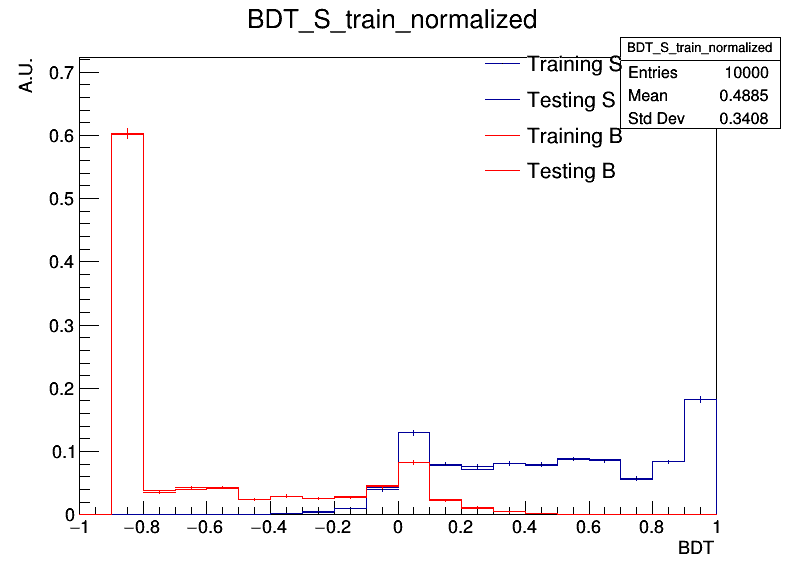

In [16]:
lIy = 0.92
lg = TLegend(0.60, lIy-0.25, 0.85, lIy)
lg.SetBorderSize(0)
lg.SetFillStyle(0)
lg.SetTextFont(42)
lg.SetTextSize(0.04)
lg.AddEntry(h1, "Training S", "lp")
lg.AddEntry(h2, "Testing S", "l")
lg.AddEntry(h3, "Training B", "lp")
lg.AddEntry(h4, "Testing B", "l")
lg.Draw()

myc.Draw()
myc.SaveAs("BDT_cla_test_1.png")

BDTG

In [17]:
h1 = norm_hists(h_train[1])
h1.GetXaxis().SetTitle("BDTG")
h1.GetYaxis().SetTitle("A.U.")
h1.Draw()
h2 = norm_hists(h_test[1])
h2.Draw("same hist")
h3 = norm_hists(h_train[3])
h3.SetLineColor(2)
h3.SetMarkerColor(2)
h3.Draw("same")
h4 = norm_hists(h_test[3])
h4.SetLineColor(2)
h4.SetMarkerColor(2)
h4.Draw("same hist")

ymin = 0
ymax = max(h1.GetMaximum(), h2.GetMaximum(), h3.GetMaximum(), h4.GetMaximum())
h1.GetYaxis().SetRangeUser(ymin, ymax*1.2)

Draw legends

Info in <TCanvas::Print>: png file BDT_cla_test_2.png has been created


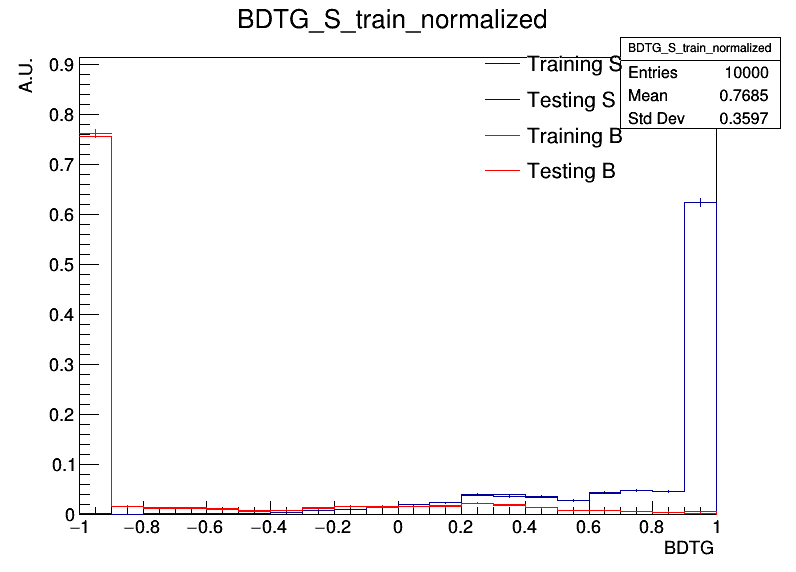

In [18]:
lIy = 0.92
lg = TLegend(0.60, lIy-0.25, 0.85, lIy)
lg.SetBorderSize(0)
lg.SetFillStyle(0)
lg.SetTextFont(42)
lg.SetTextSize(0.04)
lg.AddEntry(h1, "Training S", "lp")
lg.AddEntry(h2, "Testing S", "l")
lg.AddEntry(h3, "Training B", "lp")
lg.AddEntry(h4, "Testing B", "l")
lg.Draw()

myc.Draw()
myc.SaveAs("BDT_cla_test_2.png")

ANN MLP

In [19]:
h1 = norm_hists(h_train[4])
h1.GetXaxis().SetTitle("MLP")
h1.GetYaxis().SetTitle("A.U.")
h1.Draw()
h2 = norm_hists(h_test[4])
h2.Draw("same hist")
h3 = norm_hists(h_train[5])
h3.SetLineColor(2)
h3.SetMarkerColor(2)
h3.Draw("same")
h4 = norm_hists(h_test[5])
h4.SetLineColor(2)
h4.SetMarkerColor(2)
h4.Draw("same hist")

ymin = 0
ymax = max(h1.GetMaximum(), h2.GetMaximum(), h3.GetMaximum(), h4.GetMaximum())
h1.GetYaxis().SetRangeUser(ymin, ymax*1.2)

Draw legends

Info in <TCanvas::Print>: png file BDT_cla_test_3.png has been created


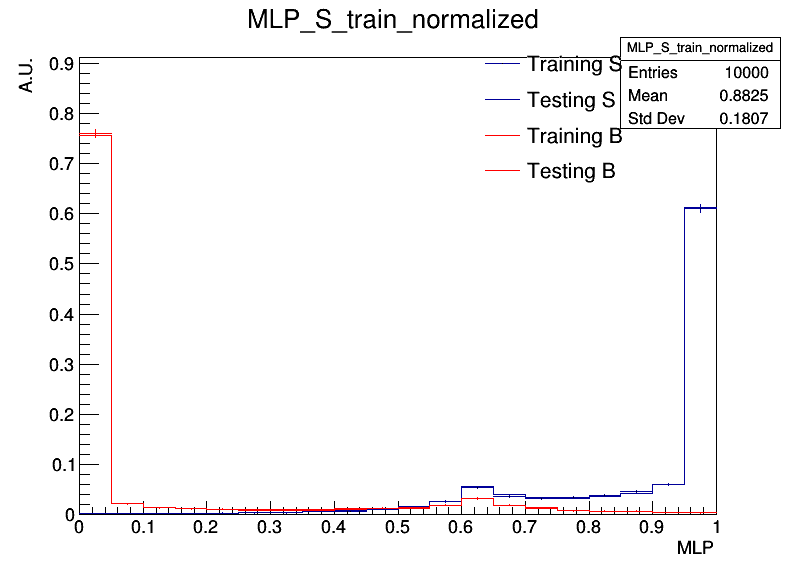

In [20]:
lIy = 0.92
lg = TLegend(0.60, lIy-0.25, 0.85, lIy)
lg.SetBorderSize(0)
lg.SetFillStyle(0)
lg.SetTextFont(42)
lg.SetTextSize(0.04)
lg.AddEntry(h1, "Training S", "lp")
lg.AddEntry(h2, "Testing S", "l")
lg.AddEntry(h3, "Training B", "lp")
lg.AddEntry(h4, "Testing B", "l")
lg.Draw()

myc.Draw()
myc.SaveAs("BDT_cla_test_3.png")

Draw all canvases 

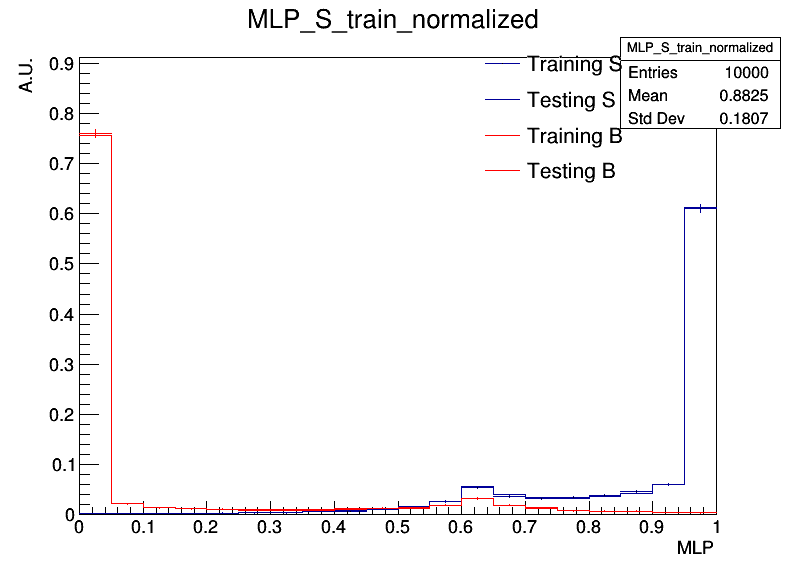

In [21]:
from ROOT import gROOT 
gROOT.GetListOfCanvases().Draw()